In [1]:
import numpy as np
import torch as pt
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
import collections as coll
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from matplotlib import cm
import gc
import numpy as np
import torch as pt
import torch
import torch.nn as nn

import torch_tensorrt

from FHNCUDAlib import FHNCUDA
import numpy as np
import torch 

loaded_module = nn.Linear(4,6)
#loaded_module.load_state_dict()

#print(loaded_module.state_dict())
st=torch.load('outputs/fhn1P/initial_conditions/network.0.pth')
#print(st)


pt.set_grad_enabled (False) 
numinputs=1
numoutputs=2
class Net(nn.Module):
    def __init__(self, numinputs, numoutputs, numlayers=4, H=10):
        super(Net, self).__init__()

        self.layers = nn.ModuleList()
        self.layers.append(nn.utils.weight_norm(nn.Linear(numinputs, H), name='weight', dim=0).cuda())

        for _ in range(numlayers - 1):
            self.layers.append(nn.utils.weight_norm(nn.Linear(H, H), name='weight', dim=0).cuda())

        self.final_layer = nn.Linear(H, numoutputs).cuda()

        for layer in self.layers:
            layer.eval()
        self.final_layer.eval()

    def forward(self, x):
        for layer in self.layers:
            x = f.silu(layer(x))

        return self.final_layer(x)

    def load(self, od):
        for k, v in od.items():
            if k.startswith('_impl.layers'):
                layer_num = int(k.split('.')[2])
                layer = self.layers[layer_num]
                if k.endswith('linear.weight'):
                    layer.weight_v.data = v
                    layer.weight_v.requires_grad = False
                elif k.endswith('linear.weight_g'):
                    layer.weight_g.data = v
                    layer.weight_g.requires_grad = False
                elif k.endswith('linear.bias'):
                    layer.bias.data = v
                    layer.bias.requires_grad = False
            elif k == '_impl.final_layer.linear.weight':
                self.final_layer.weight.data = v
                self.final_layer.weight.requires_grad = False
            elif k == '_impl.final_layer.linear.bias':
                self.final_layer.bias.data = v
                self.final_layer.bias.requires_grad = False

    def __prepare_scriptable__(self):
        for layer in self.layers:
            for hook in layer._forward_pre_hooks.values():
                if hook.__module__ == "torch.nn.utils.weight_norm" and hook.__class__.__name__ == "WeightNorm":
                    torch.nn.utils.remove_weight_norm(layer)
        return self

import itertools



def Modelrun(x=np.linspace(0, 1, num=10),t=np.linspace(0,10,num=10),M=0):
   
    gc.collect()
    torch.cuda.empty_cache()
    X=np.zeros((2,len(t)*len(x)))
    #print(itertools.product(x,t))
    i=0
    for a,b in itertools.product(x,t):
        X[:,i]=(b,a)
        i=i+1
    #print(np.shape(X))
    my2dspace = pt.tensor(X.T, requires_grad=False).float().cuda()
    M.eval()
    start_time = TIME.time()
    myOutput = M(my2dspace)
    reftime = TIME.time()- start_time
 
    myCPUOutput = myOutput.cpu()


    uu = myCPUOutput.numpy()

    #print('uu: ', uu.T[0])

    myCPUOutput.squeeze().detach().numpy()
    gc.collect()
    torch.cuda.empty_cache()
    return uu,reftime



def compileRT(modelTorch=Net(2,2)):
    gc.collect()
    torch.cuda.empty_cache()
    X=np.zeros((2,5))
    model = torch.jit.script(modelTorch).eval()  # torch module needs to be in eval (not training) mode



    trt_ts_module = torch_tensorrt.compile(modelTorch, inputs = [torch_tensorrt.Input(
            min_shape=(1,2),
            opt_shape=(50000,2),
            max_shape=(2000000*26,2),
            dtype=torch.float32)],
        enabled_precisions = torch.float32, # Run with FP32
        workspace_size = 1 << 33
    )


    gc.collect()
    torch.cuda.empty_cache()
    return trt_ts_module



net =Net(2,2,4,11)

PATH=""
od=pt.load('outputs/fhn1P/initial_conditions/network.0.pth')
net.load(od)
net=net.cuda()


model =  compileRT(net)
print("Done compiling")

Done compiling


In [3]:
!nvcc cuda.cu -o a.out  ##Estava seguindo o tutorioal do torch rt tentando encontrar uma forma de converter, tentei remover os pesos para então converte 

2
Number of rows in the CSV file:  10 13
-------------------------CUDA ----------------------------
2
Number of rows in the CSV file:  10 13
Shape cudapred  (130,)
cuda time [6.656e-05, 0.027874271, 0.000169088]
Error Calculation
mean 0.0006189384615384578
max 0.011299000000000003
-------------------------TORCH ----------------------------
(14,)
Shape netpred  (130,)
net time 0.0002181529998779297
Error Calculation
mean 0.0027455609293974338
max 0.0376015195045471


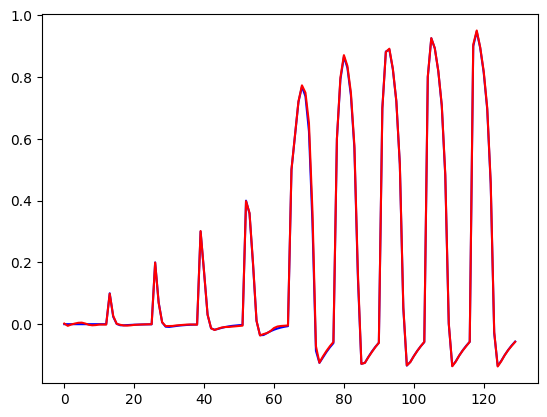

-------------------------JIT ----------------------------
(14,)
Shape netpred  (130,)
net time 0.0001895427703857422
Error Calculation
mean 0.0027455609293974338
max 0.0376015195045471


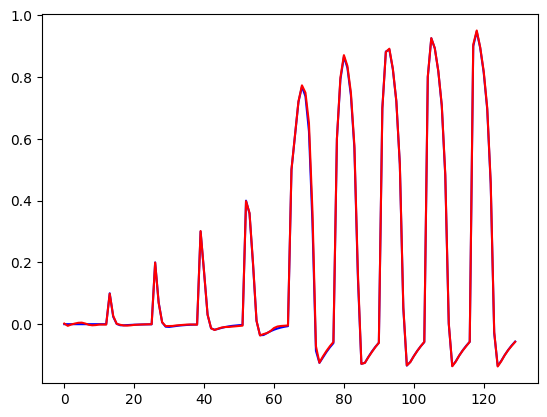

-----------------------------------------------------
-------------------------TENSOR RT ----------------------------
(14,)
Shape netpred  (130,)
net time 0.00036907196044921875
Error Calculation
mean 0.0027457018599950323
max 0.0376015195045471


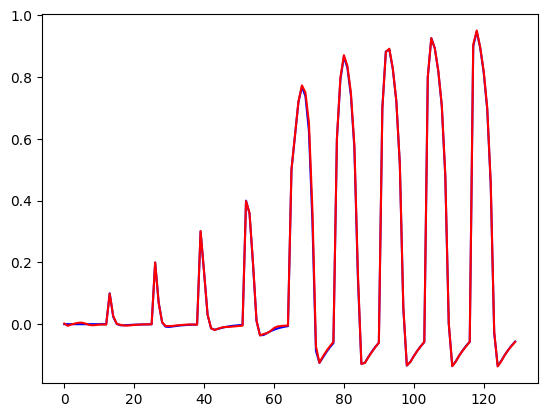

-----------------------------------------------------


In [10]:

gc.collect()
torch.cuda.empty_cache()




pt.no_grad() 
import time as TIME
x0=np.expand_dims(np.array([(0 + 0.1*i*1) for i in range(0,10)]),-1)
dt,tt=0.0001,5

rate=4000


##Cuda ref
start_time = TIME.time()
u,v ,t,p=FHNCUDA.run(x0,tt,dt,rate)
reftime = TIME.time()- start_time
p=[i/1000 for i in p[0]]
u_ref=np.array(u).flatten()




print("-------------------------CUDA ----------------------------")

###Cuda run
start_time = TIME.time()
u,v ,t,p=FHNCUDA.run(x0,tt,dt*100,rate/100)
cudatime = TIME.time()- start_time
u_num=np.array(u).flatten()
#print(np.unique(t))
p=[i/1000 for i in p[0]]
print("Shape cudapred ",np.shape(u_num))
print("cuda time",p)
print("Error Calculation")
e=((u_ref-u_num)**2)**(1/2)
print("mean",np.mean(e))
m=np.max(e)
print("max",m)

i=[a for a in range(len(e)) if e[a]==m]
x0 = [item for sublist in x0 for item in sublist]
t = [item for sublist in t for item in sublist]




##PRED NETWORK TORCH
print("-------------------------TORCH ----------------------------")
print(np.shape(t))
start_time = TIME.time()
u,net_time=Modelrun(x0,t[1:],M=net)

u_net=u.T[0].flatten()

print("Shape netpred ",np.shape(u_net))
print("net time", net_time)
print("Error Calculation")
e=((u_ref-u_net)**2)**(1/2)
print("mean",np.mean(e))
m=np.max(e)
print("max",m)
i=[a for a in range(len(e)) if e[a]==m]


plt.plot(u_ref,"b")
plt.plot(u_net,"r")

plt.show()
("-----------------------------------------------------")
#PRED NETWORK JIT
print("-------------------------JIT ----------------------------")

print(np.shape(t))
start_time = TIME.time()
u,net_time=Modelrun(x0,t[1:],M=torch.jit.script(net).cuda())
u_net=u.T[0].flatten()
print("Shape netpred ",np.shape(u_net))
print("net time", net_time)
print("Error Calculation")
e=((u_ref-u_net)**2)**(1/2)
print("mean",np.mean(e))
m=np.max(e)
print("max",m)
i=[a for a in range(len(e)) if e[a]==m]


plt.plot(u_ref,"b")
plt.plot(u_net,"r")
plt.show()
print("-----------------------------------------------------")

##PRED NETWORK RT
print("-------------------------TENSOR RT ----------------------------")
print(np.shape(t))
start_time = TIME.time()
u,net_time=Modelrun(x0,t[1:],M=model)
u_net=u.T[0].flatten()
print("Shape netpred ",np.shape(u_net))
print("net time", net_time)
print("Error Calculation")
e=((u_ref-u_net)**2)**(1/2)
print("mean",np.mean(e))
m=np.max(e)
print("max",m)
i=[a for a in range(len(e)) if e[a]==m]


plt.plot(u_ref,"b")
plt.plot(u_net,"r")
plt.show()
print("-----------------------------------------------------")


gc.collect()
torch.cuda.empty_cache()

In [5]:
!nvcc cuda.cu -o a.out